In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### 0.1. A glimpse of data
We set basic options of formatting, and take a look at data first.

In [2]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_columns', 10)
pd.set_option('precision', 4)
np.set_printoptions(precision=4)
df = pd.read_csv('pulsar_star_19206377.csv')
df

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,142.7812,48.5534,-0.1963,0.4303,2.9156,17.1975,8.1399,81.5134,0.0
1,130.0938,44.8017,-0.0054,0.1567,1.8855,18.1438,10.4598,114.0162,0.0
2,118.0859,49.6601,0.2480,-0.3804,3.3846,21.3542,7.6225,NaN,0.0
3,122.3672,52.0501,0.0499,-0.3648,1.5962,14.0558,11.2262,149.4116,0.0
4,135.8672,52.5030,0.1755,-0.4296,2.0962,14.8512,9.6974,115.4810,0.0
5,112.5312,44.1395,0.4174,0.1726,65.7341,86.6054,0.7110,-1.2639,0.0
6,123.1719,46.1832,NaN,0.5261,0.9883,11.3208,14.7632,261.5906,0.0
7,17.7578,30.8088,6.0865,38.2425,102.8294,70.8967,0.3273,-0.5075,1.0
8,115.3438,47.3830,-0.1159,0.1076,0.5610,9.2434,22.8668,570.9374,0.0
9,96.5781,44.4808,0.5766,0.7990,3.3988,18.0287,7.0321,60.3906,0.0


### 1. Data Quality Plan
We performed a series of data preprocessing techniques over raw data, including missing value handling, duplicate detection, outlier detection, class imbalance handling.
#### 1.1. Missing Value Inspection and Handling
We found at our first glimpse that missing values (i.e. `NaN`) exists in the dataset. We search over every column to detect whether a `NaN` exists. 

In [3]:
def missing_column_detect(df):
    print('Columns with missing value: ')
    for column in df.columns:
        count = df[column].isnull().sum()
        if count:
            print(column + ':', count, 'missing')

missing_column_detect(df)

Columns with missing value: 
 Excess kurtosis of the integrated profile: 1357 missing
 Standard deviation of the DM-SNR curve: 944 missing
 Skewness of the DM-SNR curve: 511 missing


Missing values may prevent classifiers from functioning properly. Here, as all features are continuous (instead of categorial), we propose to fill the `NaN` values with `mean` of corresponding column. This method is better than simply filling with 0, because 0 **may not fall in desired range (domain) of that feature**.

In [4]:
df = df.fillna(df.mean())
missing_column_detect(df)

Columns with missing value: 


#### 1.2. Duplicate Detection
We also try to detect whether duplicates exist in the dataset, only to finding none.

In [5]:
print(any(df.duplicated()))

False


#### 1.3. Outlier Detection
We calculate the minimum and maximum of each column, and find that maximum and minimum of each column are relatively reasonable. And also, no values are meaningless (e.g., standard deviation being negative).

In [6]:
print(df.min(), '\n')
print(df.max())

 Mean of the integrated profile                   6.1875
 Standard deviation of the integrated profile    24.7720
 Excess kurtosis of the integrated profile       -1.7380
 Skewness of the integrated profile              -1.7919
 Mean of the DM-SNR curve                         0.2132
 Standard deviation of the DM-SNR curve           7.3704
 Excess kurtosis of the DM-SNR curve             -2.8124
 Skewness of the DM-SNR curve                    -1.9491
target_class                                      0.0000
dtype: float64 

 Mean of the integrated profile                   185.2578
 Standard deviation of the integrated profile      91.8086
 Excess kurtosis of the integrated profile          7.8796
 Skewness of the integrated profile                63.4664
 Mean of the DM-SNR curve                         209.3002
 Standard deviation of the DM-SNR curve           109.6553
 Excess kurtosis of the DM-SNR curve               34.5398
 Skewness of the DM-SNR curve                    1191.000

#### 1.4. Class Imbalance Handling
We found that class imbalance is a serious problem for this dataset. There are only less than 10% samples whose `target_class` is 1. To handle this：
- An evaluation metric other than `accuracy` is selected;
- A stratified sampling strategy is employed;
- A train weight vector for different classes is generated.

See later sections for more details. There tricks help the training and evaluation of class imbalance datasets.

In [7]:
len(df[df['target_class']==1])

929

**Devision of train and test is done here**. 20% of total dataset are used as final test set, base on stratified sampling.

In [8]:
X, y = df.drop(['target_class'], axis=1), df['target_class']
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

sum(y_trainval==1) / sum(y==1)

0.7997847147470398

### 2. Data Normalization 
We use min-max scaling in this setting, based on the observation that it performs equally well as standard scaling under most circumstances. 

In [9]:
minn, maxx = X_trainval.min(), X_trainval.max()
X_trainval = (X_trainval - minn) / (maxx - minn)             # scaler fit only on X_trainval, 
X_test = (X_test - minn) / (maxx - minn)                     # and transform both X_trainval and X_test
X_trainval

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
828,0.5652,0.2205,0.2122,0.0430,0.0041,0.0478,0.4574,0.1969
8525,0.3688,0.1735,0.2674,0.0834,0.0083,0.1048,0.3519,0.0973
27,0.6392,0.2268,0.1864,0.0352,0.0211,0.1660,0.2420,0.0362
5710,0.6182,0.2345,0.1981,0.0452,0.0052,0.0416,0.4422,0.1992
525,0.7427,0.2982,0.1607,0.0326,0.0157,0.1059,0.2687,0.0548
2739,0.5492,0.3554,0.2400,0.0268,0.0053,0.0363,0.4500,0.0899
8672,0.5053,0.2480,0.2307,0.0400,0.0088,0.0969,0.3283,0.0832
9263,0.7309,0.4343,0.2307,0.0230,0.0647,0.3157,0.1531,0.0082
6153,0.6386,0.4767,0.1770,0.0185,0.0104,0.0689,0.3293,0.1010
8930,0.7624,0.3776,0.1865,0.0244,0.0246,0.1966,0.2305,0.0317


### 3. Evaluation Metric
In section 1.4, we have verified the class imbalance problem of dataset. We adopt `PR-AUC` as our final evaluation metric. 

Typically, accuracy is usually used to measure a classifier's performance in classification problems. But due to severe class imbalance problem in current setting, even a naive classifier which simply outputs `target_class=0` for any x has an accuracy over 90%, which makes this metric unacceptable in evaluating and comparing between models.

So we appeal to other metrics, like F-score, ROC-AUC, and PR-AUC, and choose among them. By definition, PR-AUC contains more information than F-score, so F-score is passed. And it is known that, in practice, **PR-AUC reflects model's relative improvements more clearly than ROC-AUC under class imbalance settings**, to put in another way, **PR-AUC is more discriminative**. so PR-AUC is chosen as the final metric.

`precision_recall_score` is defined to calculate PR-AUC.

In [10]:
from sklearn.metrics import precision_recall_curve, auc

def precision_recall_score(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    return pr_auc

### 4. Model Training and Comparison
This section gives an analysis of model comparison on the dataset.

In [11]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

#### 4.1. Evaluator function 
First, we define `evaluate_model_performance` function. We use a k-fold cross validation with stratified sampling, where k is set to 5 by default. Mean of PR-AUC of each run is reported.

In [12]:
def evaluate_model_performance(X, y, model, n_splits=5):
    metrics = []
    skf = StratifiedKFold(n_splits=n_splits)
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        if isinstance(X_train, pd.Series):
            X_train = X_train.to_numpy().reshape(-1,1)
            X_val = X_val.to_numpy().reshape(-1,1)
        y_pred = model.fit(X_train, y_train).predict_proba(X_val)[:, 1]
        pr_auc = precision_recall_score(y_val, y_pred)
        metrics.append(pr_auc)
    metric = np.mean(metrics)
    return metric

#### 4.2. Deciding Hyper-parameters for models
We now decide hyper-parameters for different models.

1. Decision Trees. We choose different `max_depth` and `max_features`, and model performance is generally robust. Finally, we set them to 50 and 4.
2. K-Nearest Neighbors. We choose different `n_neighbors`, and model performance is generally robust when it is between 10~20.
3. SVM(kernel='linear'). We choose different Cs and model performance is generally robust. It performs well.
4. SVM(kernel='rbf'). We choose different Cs. It performs well.
5. SVM(kernel='poly'). We choose different Cs. It performs well.
6. SVM(kernel='sigmoid'). We choose different Cs. It performs not well.

In [13]:
def test_dtc(X, y, maxf=6):
    for model in [DTC(max_depth=50), DTC(max_depth=20), DTC(max_depth=100)]:
        print(evaluate_model_performance(X, y, model))
    for model in [DTC(max_features=i) for i in range(3, maxf+1)]:
        print(evaluate_model_performance(X, y, model))
    
test_dtc(X_trainval, y_trainval)

0.8142192465829131
0.8143909670305127
0.8236380476796927
0.8135997555170617
0.8196074486786923
0.8192956261888765
0.8315492401657844


In [14]:
def test_knn(X, y):
    for model in [KNN(1), KNN(3), KNN(5), KNN(7), KNN(9), KNN(11), KNN(13), KNN(15), KNN(17), KNN(19)]:
        print(evaluate_model_performance(X, y, model))

test_knn(X_trainval, y_trainval)

0.8426677622825955
0.8979181916844933
0.9026943570950208
0.9065148449912817
0.9057635556455186
0.9061822648487967
0.9113158484988851
0.9131939205019487
0.9158662103210045
0.9162925856352789


In [15]:
def test_svc_linear(X, y):
    for model in [SVC(kernel='linear', C=0.1, probability=True),
                  SVC(kernel='linear', C=1, probability=True),
                  SVC(kernel='linear', C=10, probability=True)]: 
        print(evaluate_model_performance(X, y, model))

test_svc_linear(X_trainval, y_trainval)

0.9093002081323134
0.9194257858732167
0.9205514131069796


In [16]:
def test_svc_rbf(X, y):
    for model in [SVC(kernel='rbf', C=0.1, probability=True),
                  SVC(kernel='rbf', C=1, probability=True),
                  SVC(kernel='rbf', C=10, probability=True)]:
        print(evaluate_model_performance(X, y, model))

test_svc_rbf(X_trainval, y_trainval)

0.91667868807231
0.9169495546911591
0.917619608540393


In [17]:
def test_svc_poly(X, y):
    for model in [SVC(kernel='poly', C=0.1, probability=True),
                  SVC(kernel='poly', C=1, probability=True),
                  SVC(kernel='poly', C=10, probability=True)]:
        print(evaluate_model_performance(X, y, model))
        
test_svc_poly(X_trainval, y_trainval)

0.9193773439400156
0.9231584446051636
0.9230198826260126


In [18]:
def test_svc_sigmoid(X, y):
    for model in [SVC(kernel='sigmoid', C=0.1, probability=True),
                  SVC(kernel='sigmoid', C=1, probability=True),
                  SVC(kernel='sigmoid', C=10, probability=True)]:
        print(evaluate_model_performance(X, y, model))

test_svc_sigmoid(X_trainval, y_trainval)

0.6691754680376399
0.4138227361137464
0.38685297329580604


#### 4.3. Winner Classfier and Analysis
The winner classifier is `SVC(kernel='poly', C=1, probability=True)`. This is because there is intrinic polynomial relationship within data features, judged from the name of features.

The relative performance of 'linear', 'rbf', and 'sigmoid': linear kernel $\approx$ rbf kernel >> sigmoid kernel. It's a little surprising that 'sigmoid' performs so bad. This is probably because `sigmoid` kernels make feature less discriminative.

In [19]:
winner = SVC(kernel='poly', C=1, probability=True)  
print(evaluate_model_performance(X_test, y_test, winner))

0.8951016676309178


### 5. Feature Selection via Filter
Mutual Information (`sklearn.feature_selection.mutual_info_classif`) is used to **filter** important features that contains more information, and to rank all features based on importance. 

In [20]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_trainval, y_trainval, random_state=42)
print(mutual_info)
print("worst ---> best:")
print(np.argsort(mutual_info))

[0.1945 0.0918 0.2025 0.1991 0.1206 0.1178 0.1161 0.1146]
worst ---> best:
[1 7 6 5 4 0 3 2]


After features are ranked, train with four svm classifiers to find the differences with most discriminative or least discriminative feature subsets.

In [21]:
X_trainval_subset_best = X_trainval.iloc[:,[0,2,3]]
X_trainval_subset_worst = X_trainval.iloc[:,[1,6,7]]

for model in [SVC(kernel='linear', C=1, probability=True), SVC(kernel='rbf', C=1, probability=True),
              SVC(kernel='poly', C=1, probability=True), SVC(kernel='sigmoid', C=1, probability=True)]:
    print('best:', evaluate_model_performance(X_trainval_subset_best, y_trainval, model, n_splits=2))
    print('worst:', evaluate_model_performance(X_trainval_subset_worst, y_trainval, model, n_splits=2))

best: 0.8905197556954118
worst: 0.7690993000281955
best: 0.8679348733012127
worst: 0.7368772979694165
best: 0.8822873569765538
worst: 0.7639594703514927
best: 0.7056061253219987
worst: 0.39707516539168586


It is found that **best split of features (under the mutual information criterion) usually yield much better results than worse splits**.

### 6. Feature Selection via Wrapper
We keep only one feature at a time, and evaluate differnent model's performance based on it. This method is used as a **wrapper** to determine important features that contains more information, All models previously introduced are used as the estimator, except SVC with polynomial kernel, because it's too slow to train and this notebook fails to operate :(

In [22]:
for estimator in [DTC(max_depth=50, max_features=1, random_state=42), KNN(15), 
                  SVC(kernel='linear', C=0.1, probability=True), SVC(kernel='rbf', C=0.1, probability=True), 
                  SVC(kernel='sigmoid', C=0.1, probability=True)]: 
                  # SVC(kernel='poly', C=0.1, probability=True): too slow to converge

    metrics = []
    for column in X_trainval.columns:
        X_trainval_subset = X_trainval[column]
        metrics.append(evaluate_model_performance(X_trainval_subset, y_trainval, estimator, n_splits=2))
    print(type(estimator))
    print('metrics:', np.array(metrics))
    print('sort by index:', np.argsort(metrics))

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
metrics: [0.7008 0.4012 0.7586 0.7378 0.4243 0.3942 0.4359 0.378 ]
sort by index: [7 5 1 4 6 0 3 2]
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
metrics: [0.8267 0.4996 0.8392 0.8355 0.4565 0.4824 0.4657 0.4805]
sort by index: [4 6 7 5 1 0 3 2]
<class 'sklearn.svm._classes.SVC'>
metrics: [0.8504 0.0553 0.8328 0.8564 0.2983 0.3811 0.3729 0.3604]
sort by index: [1 4 7 6 5 2 0 3]
<class 'sklearn.svm._classes.SVC'>
metrics: [0.7923 0.4654 0.7756 0.8041 0.4299 0.4657 0.4662 0.1058]
sort by index: [7 4 1 5 6 2 0 3]
<class 'sklearn.svm._classes.SVC'>
metrics: [0.8477 0.5342 0.8251 0.7019 0.2026 0.3605 0.3765 0.2345]
sort by index: [4 7 5 6 1 3 2 0]


We can observe from above that the first, third and fourth feature of X (indexed 0,2,3), rank consistently the best when picked out one-by-one and evaluated with different classifiers.

Generally, this result is consistent with previous filtering results, which also outputs 0,2,3 as most informative feature indices. However, the least important features are not fixed across algorithms. This can be understood because variance exists among different models.

### 7. Consequences of Feature Selection
We re-evaluated all six classifiers under old best setting on selected subset of features. We found that **feature selection worsened final metric**.

In [23]:
for model in [DTC(max_depth=50, max_features=1, random_state=42), KNN(15), 
              SVC(kernel='linear', C=1, probability=True), SVC(kernel='rbf', C=1, probability=True),
              SVC(kernel='poly', C=1, probability=True), SVC(kernel='sigmoid', C=1, probability=True)]:
    print(evaluate_model_performance(X_trainval_subset_best, y_trainval, model))

0.7928059001201749
0.899879746431489
0.8915948889612426
0.8684398241840657
0.882963211029683
0.7138716190931311


Also, we tested again all models with different hyper-parameters settings, still on this subset of 3 best features. We found **the performance worsens for all settings, and the relative performance (apart from KNN) still remains**. Now, we found that the best classfier is `KNN(n_neighbors=11)`. It's generally **in line with expectation**, because observation from initial data proves that KNN is a very potential classifier under this setting.

In [24]:
print('decision tree')
test_dtc(X_trainval_subset_best, y_trainval, maxf=3)
print('knn')
test_knn(X_trainval_subset_best, y_trainval)
print('svc_linear')
test_svc_linear(X_trainval_subset_best, y_trainval)
print('svc_poly')
test_svc_poly(X_trainval_subset_best, y_trainval)
print('svc_rbf')
test_svc_rbf(X_trainval_subset_best, y_trainval)
print('svc_sigmoid')
test_svc_sigmoid(X_trainval_subset_best, y_trainval)

decision tree
0.8015780745757143
0.8052238029027479
0.8066681816588765
0.8078915291509166
knn
0.8247113571184995
0.8898982496926756
0.8967291820472573
0.8974782741492243
0.8992239261165462
0.9001301740061782
0.8999410494070176
0.899879746431489
0.9012505806769248
0.9018981747692582
svc_linear
0.8851025901603007
0.8915945649491119
0.8865875561321477
svc_poly
0.8839577253014677
0.8829528402326648
0.8853013630746258
svc_rbf
0.8762767741277344
0.8684398241840657
0.8827279654238858
svc_sigmoid
0.850952362771158
0.7138402407073337
0.68497031981432


### 8. Test Set ROC Curve Visualization
For each of the classifiers, we plot ROC curve and compute ROC-AUC score which is shown on the plot. ROC curve indicates that, before false postive rate grows, true postive rate has reached almost 1, indicating the prediction for `target_class=1` is quite satisfactory.

In addition, Linear kernel SVM with `C=1` is most suitable for the task, based on **test set performance**. 

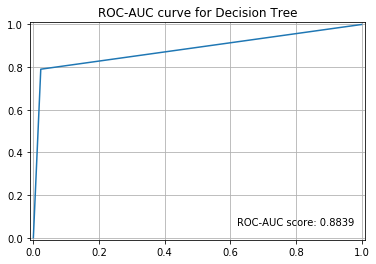

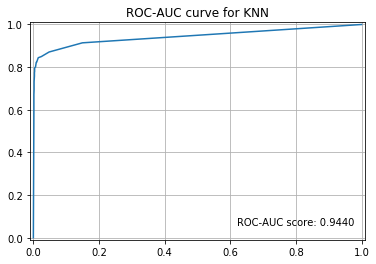

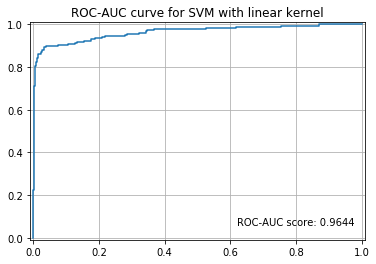

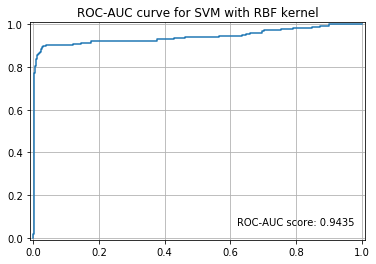

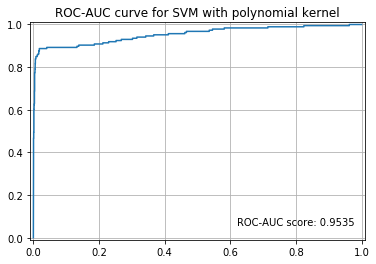

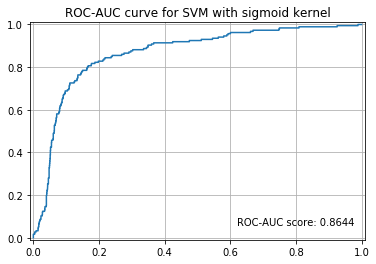

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

for model in [('Decision Tree', DTC(max_depth=50, max_features=1, random_state=42)), ('KNN', KNN(15)), 
              ('SVM with linear kernel', SVC(kernel='linear', C=1, probability=True)), 
              ('SVM with RBF kernel', SVC(kernel='rbf', C=1, probability=True)),
              ('SVM with polynomial kernel', SVC(kernel='poly', C=1, probability=True)), 
              ('SVM with sigmoid kernel', SVC(kernel='sigmoid', C=1, probability=True))]:
    y_pred = model[1].fit(X_trainval, y_trainval).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    score = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.annotate('ROC-AUC score: {:.4f}'.format(score), xy=(0.62,0.06))
    plt.xlim((-0.01,1.01))
    plt.ylim((-0.01,1.01))
    plt.grid()
    plt.title('ROC-AUC curve for {}'.format(model[0]))
    plt.show()
    

### 9. Bonus
A little more insight of data is presented here, to provide further details of data exploration.

#### 9.1. Visualization of Relationship between Features
A visualization of correlation between each feature and the target label is presented here. Observing the diagonal line, the relationship between each feature and label is very clear. Generally, each feature can partially contribute to discriminating the label of that sample, so feature selection and reduction naturally worsen final performance.

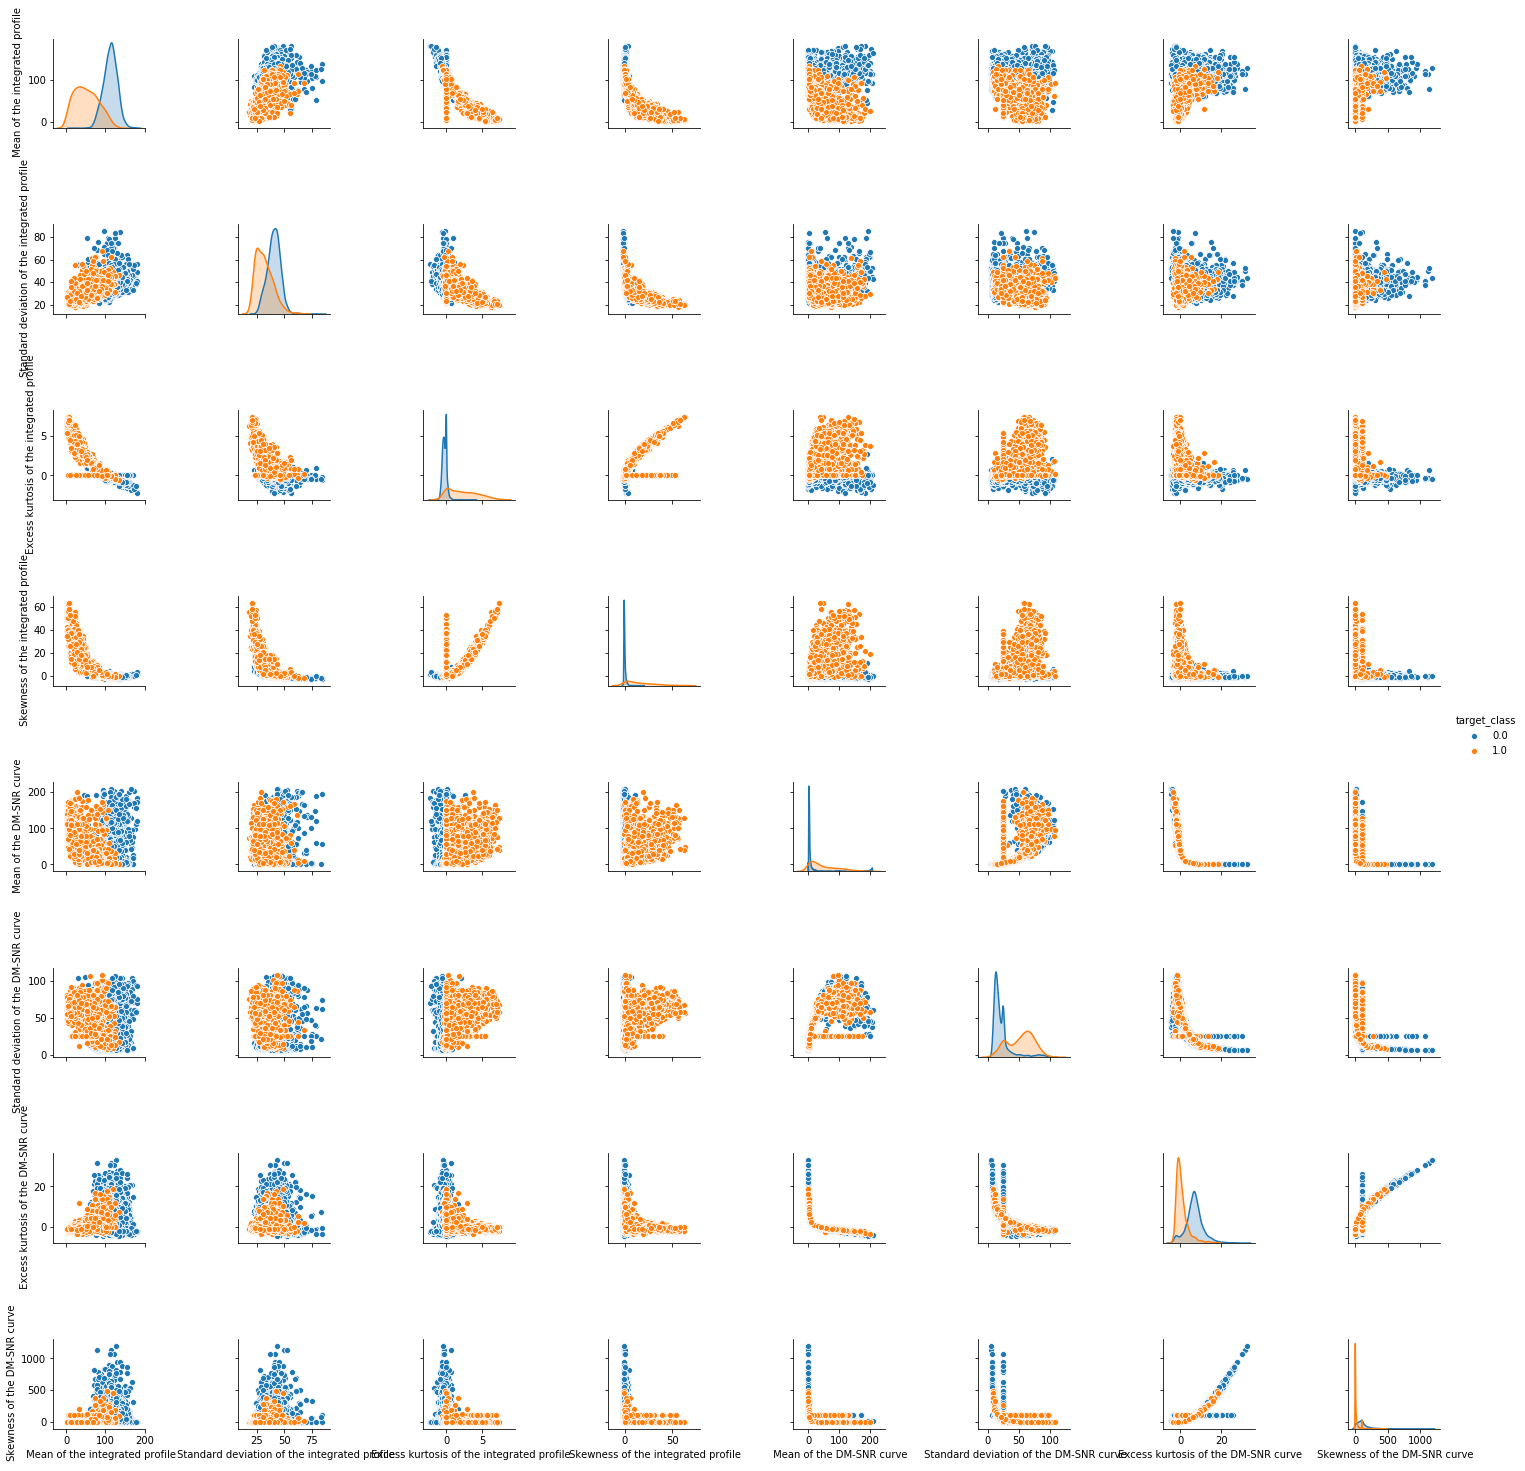

In [26]:
X_vis = X - X.mean() / X.std()
X_vis = pd.concat([X_vis, y], axis=1)
sns.pairplot(X_vis, hue='target_class')
plt.show()